# Уменьшение потребления электроэнергии на металлургическом комбинате «Стальная птица»

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Наша задача — построить модель, которая будет её предсказывать. В нашем распоряжении: данные об электродах, данные о подаче сыпучих материалов (объём и время), данные о продувке сплава газом, результаты измерения температуры, данные о проволочных материалах (объём и время). Нам нужно построить модель для определения конечной температуры сплава.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Цель исследования:**  
Построить модель с наименьшим значением *MAE*. Значение метрики должно быть меньше 6,8. В конце проверим *MAE* на тестовой выборке.

**Ход исследования**  
Данные о протекании процессов мы получим из следующих файлов:  
`'/datasets/data_arc_new.csv'`  
`'/datasets/data_bulk_new.csv'`  
`'/datasets/data_bulk_time_new.csv'`  
`'/datasets/data_gas_new.csv'`  
`'/datasets/data_temp_new.csv'`  
`'/datasets/data_wire_new.csv'`  
`'/datasets/data_wire_time_new.csv'`  
 
Исследуем данные, проведем предобработку, объединим данные по ключу, разобьем данные на выборки и приступим к прогнозированию на нескольких моделях.  
Таким образом, наше исследование пройдет в семь этапов:  
- Загрузка данных
- Исследовательский анализ и предобработка данных
- Объединение данных
- Исследовательский анализ и предобработка данных объединённого датафрейма
- Подготовка данных
- Обучение моделей машинного обучения
- Выбор лучшей модели

## Загрузка данных

Загрузим данные и выполним их первичный осмотр:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score

from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
data_arc = pd.read_csv('/datasets/data_arc_new.csv')
data_bulk = pd.read_csv('/datasets/data_bulk_new.csv')
data_bulk_time = pd.read_csv('/datasets/data_bulk_time_new.csv')
data_gas = pd.read_csv('/datasets/data_gas_new.csv')
data_temp = pd.read_csv('/datasets/data_temp_new.csv')
data_wire = pd.read_csv('/datasets/data_wire_new.csv')
data_wire_time = pd.read_csv('/datasets/data_wire_time_new.csv')

In [4]:
data = [data_arc, data_bulk, data_bulk_time, data_gas, data_temp, data_wire, data_wire_time]

In [5]:
name = ['data_arc', 'data_bulk', 'data_bulk_time', 'data_gas', 'data_temp', 'data_wire', 'data_wire_time']

In [6]:
for i in range(len(data)):
    print('                ',name[i])
    display(data[i].head())

                 data_arc


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


                 data_bulk


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


                 data_bulk_time


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


                 data_gas


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


                 data_temp


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


                 data_wire


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


                 data_wire_time


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Имеется 7 датафреймов, в которых есть общий столбец - это ключ.

## Исследовательский анализ и предобработка данных

Выполним исследовательский анализ каждого датафрейма и при необходимости выполним предобработку.

### Данные об электродах

In [7]:
data_arc

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
...,...,...,...,...,...
14871,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579
14872,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543


In [8]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


**Пропусков нет.** Начало нагрева дугой и Конец нагрева дугой должны быть типа datetime, а не object.

In [9]:
data_arc['Начало нагрева дугой']=pd.to_datetime(data_arc['Начало нагрева дугой'])
data_arc['Конец нагрева дугой']=pd.to_datetime(data_arc['Конец нагрева дугой'])

In [10]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


Посмотрим на столбец реактивная мощность:

In [11]:
data_arc[data_arc['Реактивная мощность'] < 0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


По требованию заказчика, необходимо удалить данный ключ.

In [12]:
data_arc = data_arc[data_arc['key'] !=2116]

In [13]:
data_arc

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
...,...,...,...,...,...
14871,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579
14872,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543


Добавим столбец `Время нагрева дугой` и переведем сразу в секунды:

In [14]:
data_arc['Время нагрева дугой'] = data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']
data_arc['Время нагрева дугой'] = data_arc['Время нагрева дугой'].dt.total_seconds()

/tmp/ipykernel_113/3217754260.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_arc['Время нагрева дугой'] = data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']
/tmp/ipykernel_113/3217754260.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_arc['Время нагрева дугой'] = data_arc['Время нагрева дугой'].dt.total_seconds()


Сосчитаем число итераций нагрева и произведем агрегацию данных по ключу:

In [15]:
data_arc['Число итераций нагрева']=1
data_arc = data_arc.groupby('key').agg({'Начало нагрева дугой':'first',
                                        'Конец нагрева дугой':'last',
                                        'Активная мощность':'mean',
                                        'Реактивная мощность':'mean',
                                        'Время нагрева дугой':'sum',
                                        'Число итераций нагрева':'count'})

/tmp/ipykernel_113/4288785803.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_arc['Число итераций нагрева']=1


In [16]:
data_arc = data_arc.reset_index()

In [17]:
data_arc

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Время нагрева дугой,Число итераций нагрева
0,1,2019-05-03 11:02:14,2019-05-03 11:28:37,0.607346,0.428564,1098.0,5
1,2,2019-05-03 11:34:14,2019-05-03 11:53:18,0.534852,0.363339,811.0,4
2,3,2019-05-03 12:06:54,2019-05-03 12:32:19,0.812728,0.587491,655.0,5
3,4,2019-05-03 12:39:37,2019-05-03 12:57:50,0.676622,0.514248,741.0,4
4,5,2019-05-03 13:11:13,2019-05-03 13:33:55,0.563238,0.421998,869.0,4
...,...,...,...,...,...,...,...
3208,3237,2019-09-06 11:31:25,2019-09-06 11:53:55,0.508374,0.405083,909.0,5
3209,3238,2019-09-06 12:16:25,2019-09-06 12:31:35,0.458274,0.346034,546.0,3
3210,3239,2019-09-06 14:17:00,2019-09-06 15:05:50,0.606001,0.442693,1216.0,8
3211,3240,2019-09-06 15:25:31,2019-09-06 16:24:15,0.663536,0.474710,839.0,5


### Данные о подаче сыпучих материалов (объём)

In [18]:
data_bulk

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0


Если значение пропущенно, значит подачи материала не было и можно заменить пропуск нулями

In [19]:
data_bulk = data_bulk.fillna(0)

### Данные о подаче сыпучих материалов (время)

In [20]:
data_bulk_time

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,2019-09-06 11:54:15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-06 11:49:45,NaN,2019-09-06 11:45:22,2019-09-06 11:40:06
3125,3238,NaN,NaN,2019-09-06 12:26:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-06 12:18:35,NaN,2019-09-06 12:31:49,2019-09-06 12:26:52
3126,3239,NaN,NaN,NaN,NaN,NaN,2019-09-06 15:06:00,NaN,NaN,NaN,NaN,NaN,2019-09-06 15:01:44,NaN,2019-09-06 14:58:15,2019-09-06 14:48:06
3127,3240,NaN,NaN,NaN,NaN,NaN,2019-09-06 16:24:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-06 16:07:29,2019-09-06 16:01:34


In [21]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


Аналогично предыдущему пункту заменим пропуски нулями

In [22]:
data_bulk_time = data_bulk_time.fillna(0)

### Данные о продувке сплава газом

In [23]:
data_gas

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
...,...,...
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103


In [24]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


Пропусков нет

### Результаты измерения температуры

In [25]:
data_temp

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
...,...,...,...
18087,3241,2019-09-06 16:55:01,NaN
18088,3241,2019-09-06 17:06:38,NaN
18089,3241,2019-09-06 17:21:48,NaN
18090,3241,2019-09-06 17:24:44,NaN


In [26]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


Удалим строки, где есть пропуски:

In [27]:
data_temp = data_temp.dropna()

По требованию заказчика необходимо удалить все ключи, если есть замеры температуры < 1500 градусов

In [28]:
data_temp[data_temp['Температура']<1500]

,key,Время замера,Температура
4883,867,2019-06-06 08:03:39,1191.0
6784,1214,2019-06-18 08:01:03,1208.0
9050,1619,2019-07-03 02:34:41,1218.0
11495,2052,2019-07-25 08:49:15,1227.0
14283,2561,2019-08-12 18:49:29,1204.0


In [29]:
data_temp = data_temp[(data_temp['key']!=867) &
                      (data_temp['key']!=1214) &
                      (data_temp['key']!=1619) &
                      (data_temp['key']!=2052) &
                      (data_temp['key']!=2561)]

Также по требованию заказчика необходимо удалить все ключи, где только один замер температуры:

In [30]:
data_temp = data_temp[data_temp['key'].isin(data_temp['key'].value_counts()[data_temp['key'].value_counts() > 1].index)]

Поскольку мы можем использовать только первую температуру, то создадим отдельный столбец, который позже будем подавать на вход нашей модели:

In [31]:
data_temp['Начальная температура'] = data_temp['Температура']

Предсказать нам нужно последнюю температуру по всей партии, произведем агрегацию данных:

In [32]:
data_temp = data_temp\
            .groupby('key')\
            .agg({'Время замера':'last', 'Температура':'last', 'Начальная температура': 'first'})\
            .reset_index()

In [33]:
data_temp

,key,Время замера,Температура,Начальная температура
0,1,2019-05-03 11:30:38,1613.0,1571.0
1,2,2019-05-03 11:55:09,1602.0,1581.0
2,3,2019-05-03 12:35:57,1599.0,1596.0
3,4,2019-05-03 12:59:47,1625.0,1601.0
4,5,2019-05-03 13:36:39,1602.0,1576.0
...,...,...,...,...
2466,2495,2019-08-10 11:50:47,1591.0,1570.0
2467,2496,2019-08-10 12:25:13,1591.0,1554.0
2468,2497,2019-08-10 12:53:28,1589.0,1571.0
2469,2498,2019-08-10 13:23:31,1594.0,1591.0


### Данные о проволочных материалах (объём)

In [34]:
data_wire

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


Заполним пропуски нулями:

In [36]:
data_wire = data_wire.fillna(0)

### Данные о проволочных материалах (время)

In [37]:
data_wire_time

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,2019-09-06 11:33:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,2019-09-06 12:18:35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,2019-09-06 14:36:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,2019-09-06 15:33:55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


Заполним пропуски нулями:

In [39]:
data_wire_time = data_wire_time.fillna(0)

Мы провели предобработку данных, заполнили пропуски, где это возможно, провели агрегацию данных по ключу. Также по требованию заказчика удалили полностью некоторые ключи. В следующей главе займемся формированием общей таблицы.

## Объединение данных

Данные о том в какое конкретно время были добавлены сыпучие материалы и проволочные нам не так важны, как в каком объеме они были добавлены, поэтому в итоговую таблицу не войдут `data_bulk_time` и `data_wire_time`.

In [40]:
data_arc, data_bulk, data_gas, data_temp, data_wire

(       key Начало нагрева дугой Конец нагрева дугой  Активная мощность  \
 0        1  2019-05-03 11:02:14 2019-05-03 11:28:37           0.607346   
 1        2  2019-05-03 11:34:14 2019-05-03 11:53:18           0.534852   
 2        3  2019-05-03 12:06:54 2019-05-03 12:32:19           0.812728   
 3        4  2019-05-03 12:39:37 2019-05-03 12:57:50           0.676622   
 4        5  2019-05-03 13:11:13 2019-05-03 13:33:55           0.563238   
 ...    ...                  ...                 ...                ...   
 3208  3237  2019-09-06 11:31:25 2019-09-06 11:53:55           0.508374   
 3209  3238  2019-09-06 12:16:25 2019-09-06 12:31:35           0.458274   
 3210  3239  2019-09-06 14:17:00 2019-09-06 15:05:50           0.606001   
 3211  3240  2019-09-06 15:25:31 2019-09-06 16:24:15           0.663536   
 3212  3241  2019-09-06 16:49:05 2019-09-06 17:26:15           0.609057   
 
       Реактивная мощность  Время нагрева дугой  Число итераций нагрева  
 0                0.4285

Объединим датафреймы в один по ключу:

In [41]:
data = data_arc.merge(data_bulk,on='key').merge(data_wire, on='key').merge(data_gas, on='key').merge(data_temp, on='key')

Посмотрим на таблицу:

In [42]:
data

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Время нагрева дугой,Число итераций нагрева,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Газ 1,Время замера,Температура,Начальная температура
0,1,2019-05-03 11:02:14,2019-05-03 11:28:37,0.607346,0.428564,1098.0,5,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.749986,2019-05-03 11:30:38,1613.0,1571.0
1,2,2019-05-03 11:34:14,2019-05-03 11:53:18,0.534852,0.363339,811.0,4,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.555561,2019-05-03 11:55:09,1602.0,1581.0
2,3,2019-05-03 12:06:54,2019-05-03 12:32:19,0.812728,0.587491,655.0,5,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.554793,2019-05-03 12:35:57,1599.0,1596.0
3,4,2019-05-03 12:39:37,2019-05-03 12:57:50,0.676622,0.514248,741.0,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.841219,2019-05-03 12:59:47,1625.0,1601.0
4,5,2019-05-03 13:11:13,2019-05-03 13:33:55,0.563238,0.421998,869.0,4,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.413692,2019-05-03 13:36:39,1602.0,1576.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2319,2495,2019-08-10 11:27:57,2019-08-10 11:48:05,0.792033,0.552734,723.0,4,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,256.0,0.0,129.0,223.0,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.125735,2019-08-10 11:50:47,1591.0,1570.0
2320,2496,2019-08-10 11:56:58,2019-08-10 12:23:07,0.695820,0.478672,940.0,6,0.0,0.0,0.0,63.0,0.0,0.0,0.0,0.0,0.0,122.0,0.0,256.0,0.0,129.0,226.0,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.412616,2019-08-10 12:25:13,1591.0,1554.0
2321,2497,2019-08-10 12:37:36,2019-08-10 12:51:20,1.201746,0.817364,569.0,3,0.0,0.0,0.0,85.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,230.0,0.0,124.0,226.0,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.271699,2019-08-10 12:53:28,1589.0,1571.0
2322,2498,2019-08-10 12:58:21,2019-08-10 13:20:59,0.640462,0.447964,750.0,5,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0,101.0,0.0,206.0,0.0,129.0,207.0,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.953657,2019-08-10 13:23:31,1594.0,1591.0


Все данные объединены в одну таблицу, в следующем пункте проведем анализ, удалим ненужные признаки и добавим новые.

## Исследовательский анализ и предобработка данных объединённого датафрейма

Прежде чем генерировать новые признаки, создадим копию датафрейма:

In [43]:
df = data.copy()

Время замера температуры нам неважно, можно удалить этот признак:

In [44]:
df = df.drop(['Время замера'], axis=1)

Сгенерируем новые признаки: время нагрева дугой, полную мощность и работу:

Время между замерами температур сразу переведем в секунды:

In [45]:
df['Время между замерами температур'] = df['Конец нагрева дугой'] - df['Начало нагрева дугой']
df['Время между замерами температур'] = df['Время между замерами температур'].dt.total_seconds()

In [46]:
df.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Время нагрева дугой,Число итераций нагрева,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Газ 1,Температура,Начальная температура,Время между замерами температур
0,1,2019-05-03 11:02:14,2019-05-03 11:28:37,0.607346,0.428564,1098.0,5,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.749986,1613.0,1571.0,1583.0
1,2,2019-05-03 11:34:14,2019-05-03 11:53:18,0.534852,0.363339,811.0,4,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.555561,1602.0,1581.0,1144.0
2,3,2019-05-03 12:06:54,2019-05-03 12:32:19,0.812728,0.587491,655.0,5,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.554793,1599.0,1596.0,1525.0
3,4,2019-05-03 12:39:37,2019-05-03 12:57:50,0.676622,0.514248,741.0,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.841219,1625.0,1601.0,1093.0
4,5,2019-05-03 13:11:13,2019-05-03 13:33:55,0.563238,0.421998,869.0,4,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.413692,1602.0,1576.0,1362.0


Время начала и окончания нагрева дугой нам больше не потребуется, можем удалить данные столбцы:

In [47]:
df = df.drop(['Начало нагрева дугой', 'Конец нагрева дугой'], axis=1)

Полная мощность:

In [48]:
df['Полная мощность'] = (df['Активная мощность']**2 + df['Реактивная мощность']**2) **0.5

Работа:

In [49]:
df['Работа'] = df['Время нагрева дугой'] * df['Полная мощность']

In [50]:
df

,key,Активная мощность,Реактивная мощность,Время нагрева дугой,Число итераций нагрева,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Газ 1,Температура,Начальная температура,Время между замерами температур,Полная мощность,Работа
0,1,0.607346,0.428564,1098.0,5,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.749986,1613.0,1571.0,1583.0,0.743328,816.174086
1,2,0.534852,0.363339,811.0,4,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.555561,1602.0,1581.0,1144.0,0.646593,524.386650
2,3,0.812728,0.587491,655.0,5,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.554793,1599.0,1596.0,1525.0,1.002833,656.855369
3,4,0.676622,0.514248,741.0,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.841219,1625.0,1601.0,1093.0,0.849864,629.749161
4,5,0.563238,0.421998,869.0,4,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.413692,1602.0,1576.0,1362.0,0.703789,611.592410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2319,2495,0.792033,0.552734,723.0,4,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,256.0,0.0,129.0,223.0,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.125735,1591.0,1570.0,1208.0,0.965832,698.296570
2320,2496,0.695820,0.478672,940.0,6,0.0,0.0,0.0,63.0,0.0,0.0,0.0,0.0,0.0,122.0,0.0,256.0,0.0,129.0,226.0,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.412616,1591.0,1554.0,1569.0,0.844566,793.892042
2321,2497,1.201746,0.817364,569.0,3,0.0,0.0,0.0,85.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,230.0,0.0,124.0,226.0,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.271699,1589.0,1571.0,824.0,1.453368,826.966317
2322,2498,0.640462,0.447964,750.0,5,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0,101.0,0.0,206.0,0.0,129.0,207.0,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.953657,1594.0,1591.0,1358.0,0.781577,586.183092


По требованию закачика должно быть не больше 2332 ключей и не должно быть номеров больше 2500, в нашем итоговом датафрейме получилось 2324 ключа, номер последнего ключа 2499, все условия выполняются.

Номер ключа нам больше не понадобится, удалим этот столбец:

In [51]:
df = df.drop(['key'], axis=1)

In [52]:
sum(df['Wire 5'])

0.0

Столбец wire 5 пустой, этот материал вообще не добавляли, удалим его:

In [53]:
df = df.drop(['Wire 5'], axis=1)
df.head()

,Активная мощность,Реактивная мощность,Время нагрева дугой,Число итераций нагрева,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9,Газ 1,Температура,Начальная температура,Время между замерами температур,Полная мощность,Работа
0,0.607346,0.428564,1098.0,5,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,29.749986,1613.0,1571.0,1583.0,0.743328,816.174086
1,0.534852,0.363339,811.0,4,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,12.555561,1602.0,1581.0,1144.0,0.646593,524.386650
2,0.812728,0.587491,655.0,5,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,28.554793,1599.0,1596.0,1525.0,1.002833,656.855369
3,0.676622,0.514248,741.0,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,18.841219,1625.0,1601.0,1093.0,0.849864,629.749161
4,0.563238,0.421998,869.0,4,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,5.413692,1602.0,1576.0,1362.0,0.703789,611.592410


Выше мы видим итоговую таблицу.

Выведем матрицу корреляций между всеми признаками:

<AxesSubplot:>

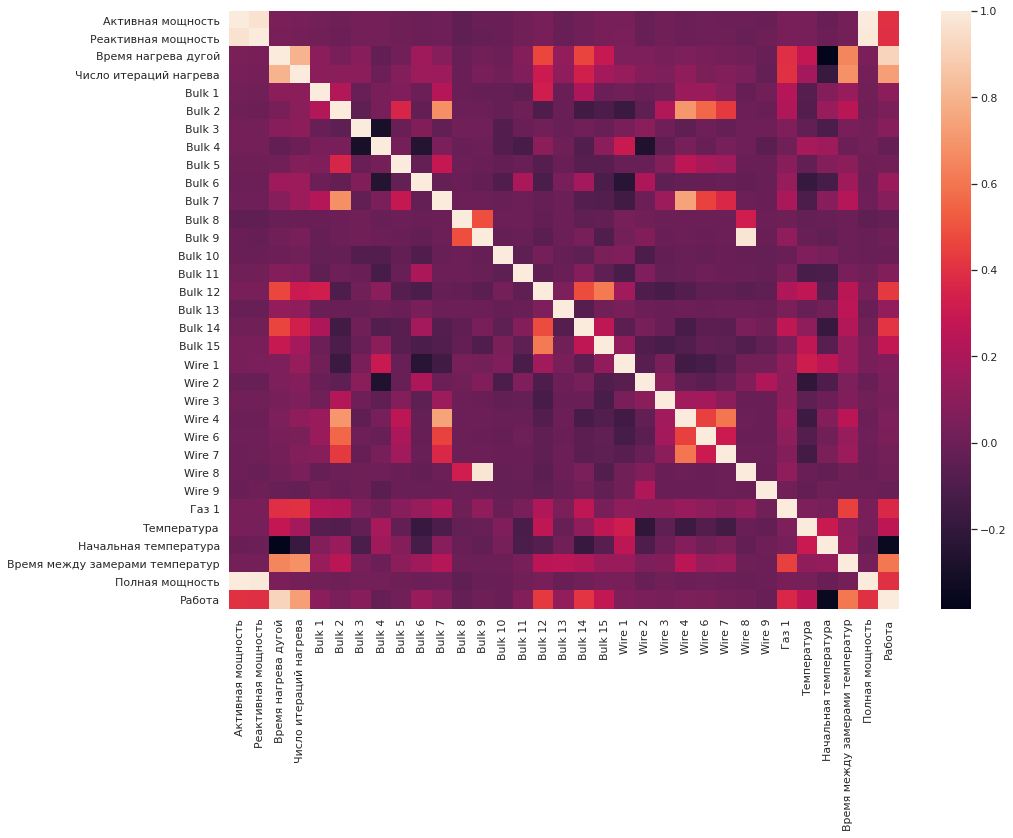

In [54]:
sns.set(rc={'figure.figsize':(15,11)})
sns.heatmap(df.corr())

Как мы видим, высокая корреляция у активной, реактивной и полной мощностей, что логично. У числа итераций и времени нагрева, что тоже логично. Также выделяются Wire 8 и Bulk 9, это интересно, видимо данные материалы часто добавляют вместе. Да и в целом наблюдается высокая корреляция между некоторыми подаваемыми материалами, но мы не знаем, что это за материалы. У целевого признака - конечной температуры высокая корреляция с временем нагрева дугой. Подадим эти признаки нашим моделям на вход.

## Подготовка данных

Разделим наши данные на обучающую (75%) и тестовую (25%) выборки.

In [55]:
train, test = train_test_split(df, test_size=0.25, random_state=150124)

Проверим правильность разбиения:

In [56]:
train.shape[0], test.shape[0]

(1743, 581)

Разбиение выполнено верно, проанализируем тестовую выборку и удалим выбросы:

In [57]:
train.describe()

,Активная мощность,Реактивная мощность,Время нагрева дугой,Число итераций нагрева,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9,Газ 1,Температура,Начальная температура,Время между замерами температур,Полная мощность,Работа
count,1743.000000,1743.000000,1743.000000,1743.000000,1743.000000,1743.000000,1743.000000,1743.000000,1743.000000,1743.000000,1743.000000,1743.000000,1743.000000,1743.000000,1743.000000,1743.000000,1743.000000,1743.000000,1743.000000,1743.000000,1743.000000,1743.000000,1743.000000,1743.000000,1743.000000,1743.000000,1743.000000,1743.000000,1743.000000,1743.000000,1743.000000,1743.000000,1743.000000
mean,0.664128,0.488610,806.185313,4.684452,3.541021,1.427998,47.657487,37.310958,2.529547,23.773379,2.048193,0.028112,0.556512,4.886403,4.218589,212.176133,1.339644,156.002295,122.092369,102.421988,17.737899,2.665437,0.308473,1.004259,0.008499,0.390113,0.354728,11.429080,1593.271945,1587.274240,1982.954676,0.824748,666.445768
std,0.129350,0.098599,343.614307,1.632134,12.739481,18.844471,74.988880,58.483944,23.044910,57.770705,29.613429,1.173674,7.011970,20.527508,22.041862,157.299375,16.044981,80.469882,84.195593,43.734387,34.143596,25.343679,4.757444,8.521450,0.237762,4.971451,3.594087,6.476495,11.326059,23.472544,1349.628683,0.161398,315.188453
min,0.267676,0.196228,57.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008399,1541.000000,1519.000000,57.000000,0.331897,33.430208
25%,0.576908,0.418988,578.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,106.000000,0.000000,108.000000,0.000000,73.201438,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.289880,1587.000000,1571.000000,1321.000000,0.715419,455.200850
50%,0.654441,0.483222,777.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,150.000000,112.000000,100.376639,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.138850,1593.000000,1587.000000,1738.000000,0.816140,632.723722
75%,0.742841,0.545841,991.500000,6.000000,0.000000,0.000000,81.000000,77.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,303.500000,0.000000,204.000000,204.000000,127.249199,22.016799,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.223185,1598.000000,1603.000000,2393.000000,0.922150,836.065053
max,1.243889,0.960763,4189.000000,16.000000,185.000000,282.000000,445.000000,281.000000,603.000000,503.000000,576.000000,49.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000,330.314424,282.780152,385.008668,113.231044,145.139283,8.490040,102.762401,55.000397,77.995040,1653.000000,1660.000000,23485.000000,1.571727,4265.032401


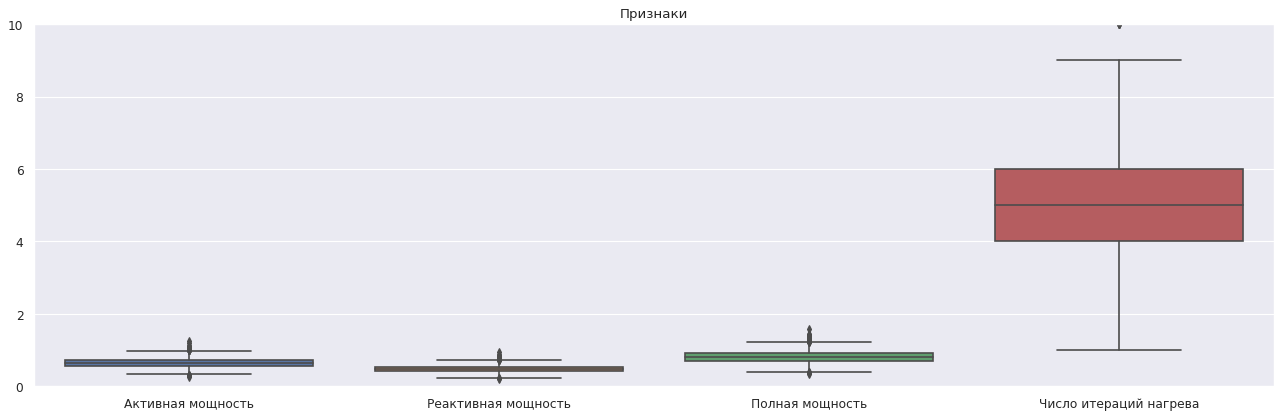

In [58]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(20,6), dpi= 80)
sns.boxplot(data=train[['Активная мощность',
                        'Реактивная мощность',
                        'Полная мощность',
                        'Число итераций нагрева'
                        ]],
           ax=ax)

ax.set_ylim(0, 10)
plt.title("Признаки");

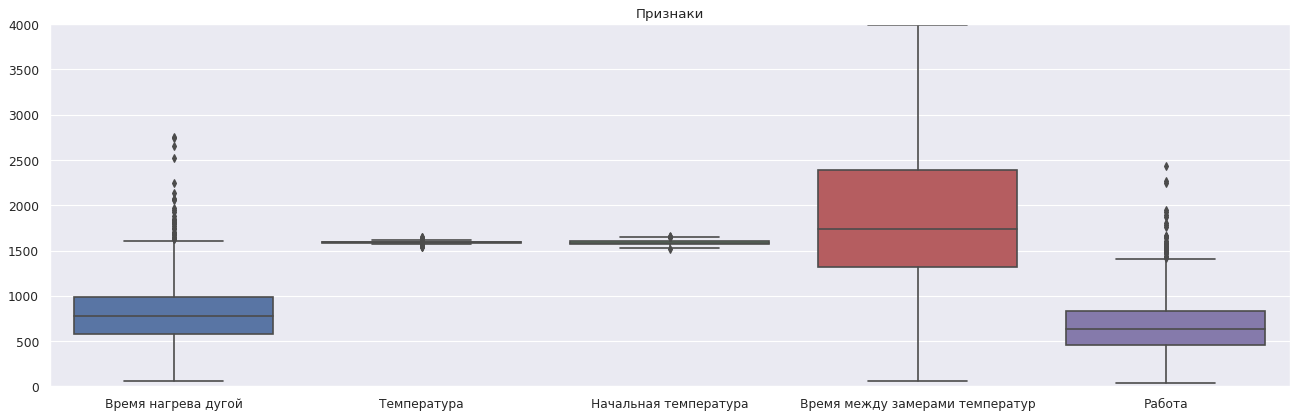

In [59]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(20,6), dpi= 80)

sns.boxplot(data=train[['Время нагрева дугой',
                        'Температура',
                        'Начальная температура',
                        'Время между замерами температур',
                        'Работа']],
           ax=ax)

ax.set_ylim(0, 4000)
plt.title("Признаки");

Уменьшим тренировочную выборку, убрав слишком высокие и низкие значения температур:

In [60]:
train = train[train['Температура']>1570]
train = train[train['Температура']<1622]

In [61]:
train

,Активная мощность,Реактивная мощность,Время нагрева дугой,Число итераций нагрева,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9,Газ 1,Температура,Начальная температура,Время между замерами температур,Полная мощность,Работа
26,0.724562,0.524504,768.0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,202.0,153.0,118.241760,30.051842,0.0,0.0,0.0,0.0,0.0,0.0000,10.404299,1604.0,1578.0,1556.0,0.894480,686.960782
784,0.652198,0.497214,1046.0,6,0.0,0.0,0.0,105.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,257.0,0.0,100.0,202.0,148.215609,0.000000,0.0,0.0,0.0,0.0,0.0,0.0000,17.836306,1596.0,1568.0,2704.0,0.820113,857.837694
695,0.707617,0.525585,974.0,5,0.0,0.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,103.0,0.0,256.0,0.0,16.005600,40.203281,0.0,0.0,0.0,0.0,0.0,0.0000,1.367004,1608.0,1577.0,1937.0,0.881454,858.536534
724,0.555646,0.407964,531.0,4,0.0,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,120.276009,0.000000,0.0,0.0,0.0,0.0,0.0,0.0000,7.464106,1599.0,1592.0,1065.0,0.689331,366.034527
886,0.732403,0.610455,944.0,5,0.0,0.0,49.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,159.0,0.0,123.0,103.0,122.241600,195.225677,0.0,0.0,0.0,0.0,0.0,35.0168,9.127801,1587.0,1561.0,1802.0,0.953451,900.057898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
645,0.651677,0.487988,511.0,4,0.0,0.0,197.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,153.0,154.0,58.312797,11.189360,0.0,0.0,0.0,0.0,0.0,0.0000,11.435276,1590.0,1594.0,1310.0,0.814134,416.022644
1505,0.654276,0.517354,192.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,320.0,0.0,24.055201,10.163919,0.0,0.0,0.0,0.0,0.0,0.0000,6.645187,1574.0,1586.0,192.0,0.834106,160.148286
639,0.732386,0.553894,545.0,4,0.0,0.0,0.0,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,255.0,0.0,154.0,204.0,97.297196,51.332317,0.0,0.0,0.0,0.0,0.0,0.0000,17.532679,1584.0,1631.0,2302.0,0.918253,500.447661
2052,0.801390,0.568271,687.0,4,0.0,0.0,0.0,154.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,330.0,0.0,136.0,228.0,118.067039,31.064800,0.0,0.0,0.0,0.0,0.0,0.0000,6.703613,1587.0,1561.0,1396.0,0.982424,674.925379


Предсказать нам нужно столбец `Температура`. Назначим его целевым столбцом.

In [62]:
features_train = train.drop(['Температура'], axis=1)
target_train = train['Температура']
features_test = test.drop(['Температура'], axis=1)
target_test = test['Температура']

Отлично, можем приступать к обучению моделей.

## Обучение моделей машинного обучения

Таким образом, в обучающие признаки вошли следующие столбцы:

In [63]:
features_train.columns

Index(['Активная мощность', 'Реактивная мощность', 'Время нагрева дугой',
       'Число итераций нагрева', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4',
       'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11',
       'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15', 'Wire 1', 'Wire 2',
       'Wire 3', 'Wire 4', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9', 'Газ 1',
       'Начальная температура', 'Время между замерами температур',
       'Полная мощность', 'Работа'],
      dtype='object')

Рассмотрим несколько моделей:

### Дерево решений

Первой нашей моделью будет простое дерево решений

С помощью `TimeSeriesSplit` будем разбивать нашу тренировочную выборку на подвыборки:

In [64]:
%%time
cv = TimeSeriesSplit(n_splits=3).split(features_train)
tree_model = DecisionTreeRegressor()
tree_parametrs = {'max_depth': range(1, 11),
                  'random_state': [150124]}
#Применим GridSearchCV с кросс-валидацией
tree_grid = GridSearchCV(tree_model, tree_parametrs, scoring='neg_mean_absolute_error', cv=cv)
tree_grid.fit(features_train, target_train)

print('MAE наилучшей модели:', (tree_grid.best_score_ * (-1)))
print('Глубина дерева =', tree_grid.best_params_['max_depth'])

MAE наилучшей модели: 6.693167520392222
Глубина дерева = 4
CPU times: user 252 ms, sys: 99 µs, total: 252 ms
Wall time: 259 ms


Неплохое значение метрики при глубине дереве 4, рассмотрим ещё модели.

### LightGBM

Следующей нашей моделью будет бустинг:

In [65]:
%%time
cv = TimeSeriesSplit(n_splits=3).split(features_train)
lgbm_model = LGBMRegressor()
lgbm_parametrs = {'boosting_type': ['gbdt', 'dart', 'goss'],
                 'learning_rate': [0.01, 0.03, 0.05], #Рассмотрим различные гиперпараметры
                 'n_estimators': [38],
                 'num_leaves': [31],
                 'random_state': [150124]}
#Применим GridSearchCV с кросс-валидацией
lgbm_grid = GridSearchCV(lgbm_model, lgbm_parametrs, scoring='neg_mean_absolute_error', cv=cv)
lgbm_grid.fit(features_train, target_train, verbose=False)

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. 

CPU times: user 11.3 s, sys: 42.8 ms, total: 11.4 s
Wall time: 11.5 s


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7fe4c5d1d120>,
             estimator=LGBMRegressor(),
             param_grid={'boosting_type': ['gbdt', 'dart', 'goss'],
                         'learning_rate': [0.01, 0.03, 0.05],
                         'n_estimators': [38], 'num_leaves': [31],
                         'random_state': [150124]},
             scoring='neg_mean_absolute_error')

In [66]:
print('MAE для LGBMRegressor:', (lgbm_grid.best_score_ * (-1)))
print('boosting_type =', lgbm_grid.best_params_['boosting_type'])
print('learning_rate =', lgbm_grid.best_params_['learning_rate'])

MAE для LGBMRegressor: 5.900440967758619
boosting_type = gbdt
learning_rate = 0.05


Отличное значение метрики, но рассмотрим ещё одну модель.

### CatBoost

И последней нашей моделью будет бустинг, разработанный компанией Яндекс:

In [67]:
%%time
cv = TimeSeriesSplit(n_splits=3).split(features_train)
cat_model = CatBoostRegressor()
cat_parametrs = {'learning_rate': [0.01, 0.03, 0.1], #Рассмотрим различные гиперпараметры
                 'depth': [6],
                 'random_state': [150124]}
#Применим GridSearchCV с кросс-валидацией
cat_grid = GridSearchCV(cat_model, cat_parametrs, scoring='neg_mean_absolute_error', cv=cv)
cat_grid.fit(features_train, target_train, verbose=False)

CPU times: user 29.7 s, sys: 567 ms, total: 30.2 s
Wall time: 39 s


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7fe4c5ce3190>,
             estimator=<catboost.core.CatBoostRegressor object at 0x7fe4c5d1e910>,
             param_grid={'depth': [6], 'learning_rate': [0.01, 0.03, 0.1],
                         'random_state': [150124]},
             scoring='neg_mean_absolute_error')

In [68]:
print('MAE наилучшей модели:', (cat_grid.best_score_ * (-1)))
print('Коэффициент скорости обучения =', cat_grid.best_params_['learning_rate'])
print('Глубина =', cat_grid.best_params_['depth'])

MAE наилучшей модели: 5.6910869273144895
Коэффициент скорости обучения = 0.03
Глубина = 6


Это лучшее зачение метрики на кросс-валидации, именно эту модель и будем проверять на тестовой выборке.

## Выбор лучшей модели

Лучше всего себя показала модель CatBoost, протестриуем нашу лучшую модель на тестовой выборке:

In [69]:
cat_model = CatBoostRegressor(learning_rate=0.03,
                              depth=6,
                              verbose=False) 
cat_model.fit(features_train, target_train)
cat_predict = cat_model.predict(features_test)

print('MAE CatBoostRegressor на тестовой выборке:', mean_absolute_error(target_test, cat_predict))
print('Значение метрики r2 на тестовой выборке:', r2_score(target_test, cat_predict))

MAE CatBoostRegressor на тестовой выборке: 6.05271596683814
Значение метрики r2 на тестовой выборке: 0.45884097264657897


Отличное значение MAE, которое выполнят условие заказчика. Дополнительно рассчитали метрику R2 (коэффициент детерминации), которая показывает насколько лучше наша модель может делать предсказания, чем среднее арифметическое. Коэффициент получился 0,46 а это значит что наша модель неплохо умеет предсказывать конечную температуру.

Проведем проверку модели на адекватность:

In [70]:
dummy_model = DummyRegressor(strategy='median')
dummy_model.fit(features_train, target_train)
mean_absolute_error(target_test, dummy_model.predict(features_test))

7.903614457831325

Dummy модель, которая заполняет все значения медианным значением, имеет метрику MAE 7.9

Исследуем важность признаков у лучшей модели:

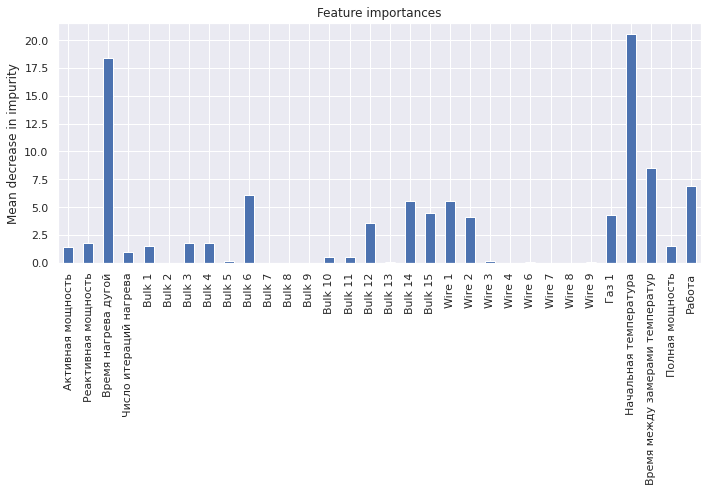

In [74]:
feature_names = features_train.columns 
model = CatBoostRegressor(learning_rate=0.03,
                          depth=6,
                          verbose=False,
                          random_state=150124)
model.fit(features_train, target_train)
importances = model.feature_importances_
model_importances = pd.Series(importances, index=feature_names)

std = np.std([model.feature_importances_ for tree in str(1000)], axis=0)

fig, ax = plt.subplots(figsize=(10,7))
model_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Как ранее нам показала тепловая карта, высокая корреляция с целевым признаком у времени нагрева дугой и начальной температурой, и именно эти признаки оказывают наибольшее влияние на прогнозирование модели. Также высокое влияние оказали время между замерами температур и работа, которые кстати напрямую связаны со временеи нагрева дугой.

## Общий вывод и рекомендации заказчику

В данной работе перед нами стояла задача построить модель, которая умеет определять конечную температуру сплава.  
Первым делом была проведена предобработка данных - удалены некоторые ключи, созданы дополнительные признаки и все датафреймы были объединены в один.  
Далее мы разделили данные на обучающую и тестовую выборки.  
Было обучено несколько моделей, в качестве оценки моделей при помощи кросс-валидации была использована метрика MAE и вот что у нас получилось:    

Модель LightGBM обучалась всего **12 секунд**, а значение метрики - **5.900440967758619**,  

У модели CatBoost лучшее значение метрики MAE - **5.6910869273144895** и время обучения **40 секунд**,  

Быстрее всех обучилось Дерево решений - менее чем за **секунду**, но MAE велика - **6.693167520392222**   

Итоговое значение MAE уже на тестовой выборке модели CatBoost получилось: **6.05271596683814**

Модель CatBoost отлично прогнозирует конечную температуру сплава и имеет небольшое время обучения. Данную модель можно запускать в производство, она поможет уменьшить потребление электроэнергии и таким образом сэкономить деньги металлургического комбината.